<a href="https://colab.research.google.com/github/gromag/Gym-NeuralNetwork/blob/dgans-experiments/Gym%208%20-%20GANs/Learner%20Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Deepfakes with Keras

![DCGAN](https://github.com/gromag/Gym-NeuralNetwork/blob/master/Gym%208%20-%20GANs/DCGAN.png?raw=1)

# Task 1: Importing Libraries and Helper Functions

Please note: If you haven't already, please install the required packages by executing the code cell below.

In [1]:
!pip3 install tensorflow==2.7.0 pillow matplotlib
!pip3 install git+https://github.com/am1tyadav/tfutils.git

  Cloning https://github.com/am1tyadav/tfutils.git to /tmp/pip-req-build-qsmxhd_k
  Running command git clone -q https://github.com/am1tyadav/tfutils.git /tmp/pip-req-build-qsmxhd_k
  Created wheel for tfutils: filename=tfutils-0.0.1-py3-none-any.whl size=6454 sha256=36d9e6bae7c1deebdea09d9c2af763447d4ab1064d7363bdc0d6f76f2ed5880e
  Stored in directory: /tmp/pip-ephem-wheel-cache-4pye2mgy/wheels/76/26/c1/59c11d1b3edc8644c22d4251d283ce58f43ca5e99eb08268ad
Successfully built tfutils


In [19]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import os
import tfutils

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from PIL import Image

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


# Task 2: Importing and Plotting the Data

In [3]:
def load_data(one_hot=True):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    print(x_train.shape)
    size = x_train.shape[1] * x_train.shape[2] * x_train.shape[3]
    x_train = np.reshape(x_train, (x_train.shape[0], size))/255.
    x_test = np.reshape(x_test, (x_test.shape[0], size))/255.
    y_train = np.reshape(y_train, (y_train.shape[0]))
    y_test = np.reshape(y_test, (y_test.shape[0]))
    if one_hot:
        y_train = tf.keras.utils.to_categorical(y_train)
        y_test = tf.keras.utils.to_categorical(y_test)
    return (x_train, y_train), (x_test, y_test)

In [4]:
def load_subset(classes, x, y):
    """
    y should not be one hot encoded
    """
    x_subset = None
    for i, c in enumerate(classes):
        indices = np.squeeze(np.where(y == c))
        x_c = x[indices]
        if i == 0:
            x_subset = np.array(x_c)
        else:
            x_subset = np.concatenate([x_subset, x_c], axis=0)
    return x_subset

In [5]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.6250256440000044
GPU (s):
0.05347187999998937
GPU speedup over CPU: 67x


In [6]:
(x_train, y_train), (x_test, y_test) = load_data(one_hot=False)
x_train = load_subset([5], x_train, y_train)
x_test = load_subset([5], x_test, y_test)
print(x_train.shape)
print(x_test.shape)
x = np.concatenate([x_train, x_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

170508288/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3)
(5000, 3072)
(1000, 3072)


In [7]:
def plot_ten_random_examples(plt, x, y, p=None):
    indices = np.random.choice(range(0, x.shape[0]), 10, replace=False)
    if p is None:
        p = y
    plt.figure(figsize=(10, 5))
    for i, index in enumerate(indices):
        plt.subplot(2, 5, i+1)
        plt.imshow(x[index].reshape((32, 32, 3)), cmap='coolwarm')
        plt.xticks([])
        plt.yticks([])
        if y[index] == p[index]:
            col = 'g'
        else:
            col = 'r'
        plt.xlabel(str(p[index]), color=col)
    return plt

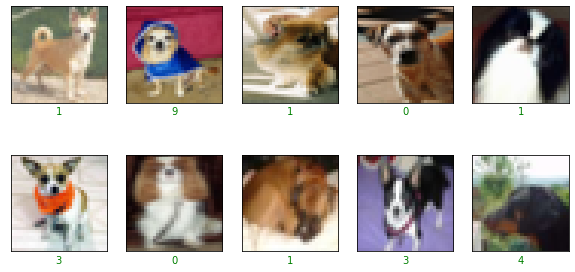

In [8]:
plot_ten_random_examples(plt, x, y).show()

# Task 3: Discriminator

![Artist and Critic](https://github.com/gromag/Gym-NeuralNetwork/blob/master/Gym%208%20-%20GANs/artist_critic.png?raw=1)

In [25]:

discriminator = Sequential([
    Conv2D(64, 3, strides=2, input_shape=(32,32,3)),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(128, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(256, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    Flatten(),
    Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 15, 15, 64)        1792      
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 15, 15, 64)        0         
                                                                 
 batch_normalization_26 (Bat  (None, 15, 15, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_41 (Conv2D)          (None, 6, 6, 128)         204928    
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 6, 6, 128)         0         
                                                                 
 batch_normalization_27 (Bat  (None, 6, 6, 128)        512       
 chNormalization)                                     

In [26]:
((25 * 25 * 32) - 2 +1)/26

769.1923076923077

In [27]:
generator = Sequential([
    Dense(256, activation='relu', input_shape=(1,)),
    
    Reshape((1, 1, 256)),
    
    Conv2DTranspose(256, 5, activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(128, 5, activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(64, 5, strides=2, activation='relu'),
    BatchNormalization(),

    Conv2DTranspose(32, 5, activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(3, 8, activation='sigmoid')
])

generator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 256)               512       
                                                                 
 reshape_2 (Reshape)         (None, 1, 1, 256)         0         
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 5, 5, 256)        1638656   
 Transpose)                                                      
                                                                 
 batch_normalization_29 (Bat  (None, 5, 5, 256)        1024      
 chNormalization)                                                
                                                                 
 conv2d_transpose_11 (Conv2D  (None, 9, 9, 128)        819328    
 Transpose)                                                      
                                                      

tf.Tensor([0.6540637], shape=(1,), dtype=float32)
[-0.48113013]


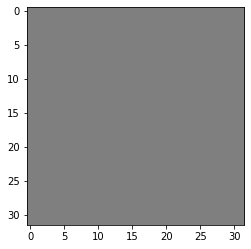

In [28]:
tf.debugging.set_log_device_placement(True)
noise1 = tf.random.uniform(shape=[1])
print(noise1)
noise = np.random.randn(1)

print(noise)
gen_image = generator.predict(noise)[0]
a = gen_image.max(axis=2)
b = gen_image.min(axis=2)
c = gen_image.mean(axis=2)
d = [[[] for r in range(32)] for r2 in range(32)]
for h, d1 in enumerate(gen_image):
   for w,d2 in enumerate(d1):
     d[h][w] = [d2[0], d2[1], d2[2]]

plt.figure()
# plt.imshow(np.reshape(a, (32, 32)), cmap='PiYG')
plt.imshow(np.reshape(d, (32, 32, 3)), interpolation="nearest")
# plt.imshow(np.reshape(c, (32, 32)), cmap='PiYG')
# plt.imshow(gen_image, interpolation='nearest')
# plt.imshow(np.reshape(gen_image, (32, 32, 3)), interpolation='nearest')
plt.show()

# Task 5: Generative Adversarial Network (GAN)

In [16]:
input_layer = tf.keras.layers.Input(shape=(1,))
gen_out = generator(input_layer)
disc_out = discriminator(gen_out)

gan = Model(
    input_layer,
    disc_out
)

discriminator.trainable = False

gan.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 sequential_2 (Sequential)   (None, 32, 32, 3)         2722659   
                                                                 
 sequential (Sequential)     (None, 1)                 1028225   
                                                                 
Total params: 3,750,884
Trainable params: 2,721,699
Non-trainable params: 1,029,185
_________________________________________________________________


# Tasks 6 and 7: Training the GAN

In [17]:
epochs = 25
batch_size = 128
steps_per_epoch = int(2 * x.shape[0]/batch_size)

print('Steps per epoch=', steps_per_epoch)

Steps per epoch= 93


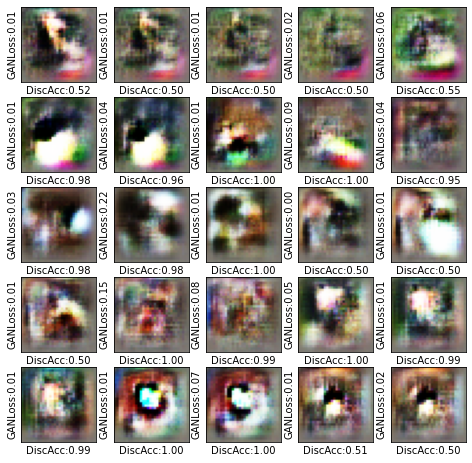

In [93]:
dp = tfutils.plotting.DynamicPlot(plt, 5, 5, (8, 8))

for e in range(0, epochs):
    dp.start_of_epoch(e)
    
    for step in range(0, steps_per_epoch):
        true_examples = x[int(batch_size/2)*step:int(batch_size/2)*(step+1)]
        true_examples = np.reshape(true_examples, (true_examples.shape[0], 32, 32, 3))
        
        noise = np.random.randn(int(batch_size/2), 1)
        gen_examples = generator.predict(noise)
        
        x_batch = np.concatenate([gen_examples, true_examples], axis = 0)
        y_batch = np.array([0]*int(batch_size/2) + [1]*int(batch_size/2))
        
        indices = np.random.choice(range(batch_size), batch_size, replace=False)
        
        x_batch = x_batch[indices]
        y_batch = y_batch[indices]
        
        discriminator.trainable = True        
        discriminator.train_on_batch(x_batch, y_batch)
        discriminator.trainable = False
        
        loss, _ = gan.train_on_batch(noise, np.ones((int(batch_size/2), 1)))
        
        _,acc = discriminator.evaluate(x_batch, y_batch, verbose=False)
        
    noise = np.random.randn(1, 1)
    gen_image = generator.predict(noise)[0]
    gen_image = np.reshape(gen_image, (32, 32, 3))
    dp.end_of_epoch(gen_image, 'binary', 'DiscAcc:{:.2f}'.format(acc), 'GANLoss:{:.2f}'.format(loss))
    

In [86]:
3072/3

1024.0